[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kdlamb/SP2-VAE/blob/main/SP2_2DLatentSpace.ipynb)

## SP2 2D Latent Space Analysis
This notebook uses the pyroVED library to analyze signals from the Single Particle Soot Photometer. Here we use a 2D latent space for the scattering and incandescent channels from the NOAA SP2.

## Download the L-II signal data
You can download the NOAA SP2 data directly from the [Zenodo repository](https://zenodo.org/records/15800436) using the following code (can be slow). Alternatively, you can first download the data directly to your computer and then upload the files to Colab.

In [ ]:
!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_train.npy"
!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_train.npy"
!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_val.npy"
!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_val.npy"
!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_test.npy"
!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_test.npy"

--2025-11-07 19:52:48--  https://zenodo.org/records/15800436/files/Lab_X_train.npy
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1793049728 (1.7G) [application/octet-stream]
Saving to: ‘Lab_X_train.npy’

Lab_X_train.npy      12%[=>                  ] 218.31M  2.86MB/s    eta 8m 53s ^C


## Install packages and load in libraries

In [10]:
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done


In [11]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [12]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

In [13]:
# for reproducibility
np.random.seed(0)
torch.manual_seed(0)

## Preprocess SP2 Data Sets

In [18]:
X_train = np.load("Lab_X_train.npy")
Y_train = np.load("Lab_Y_train.npy")

X_val = np.load("Lab_X_val.npy")
Y_val = np.load("Lab_Y_val.npy")

X_test = np.load("Lab_X_test.npy")
Y_test = np.load("Lab_Y_test.npy")

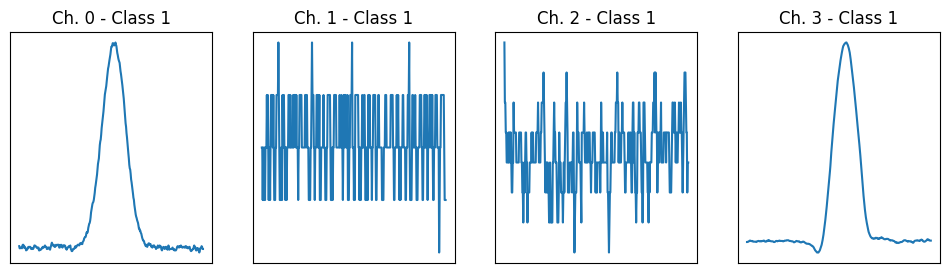

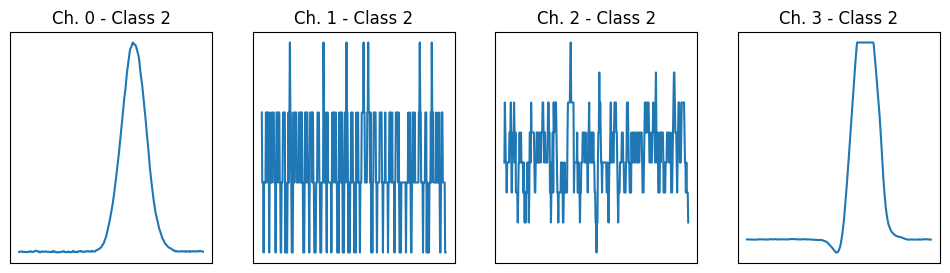

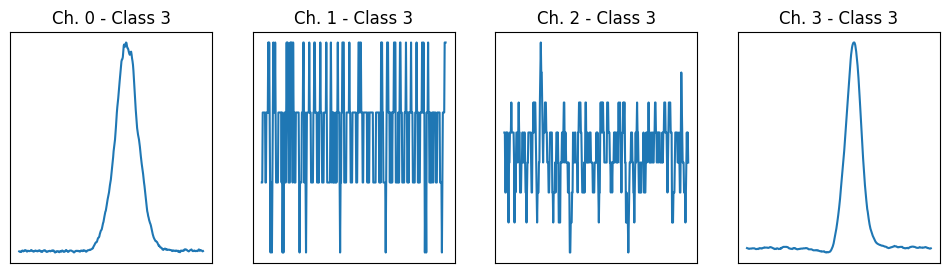

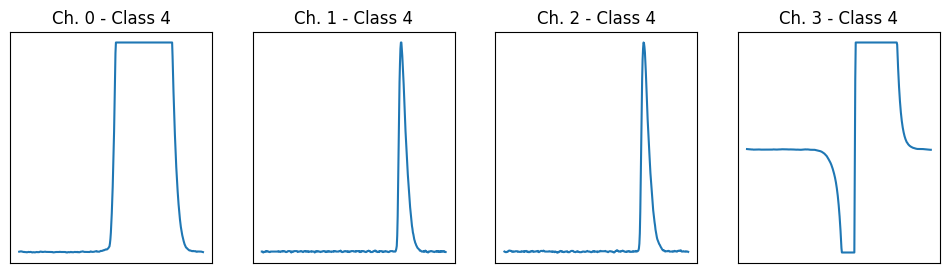

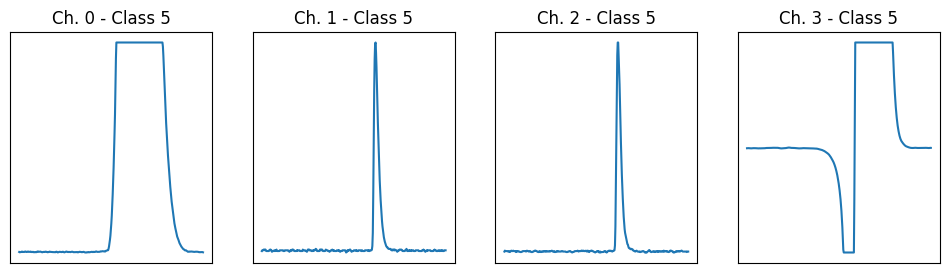

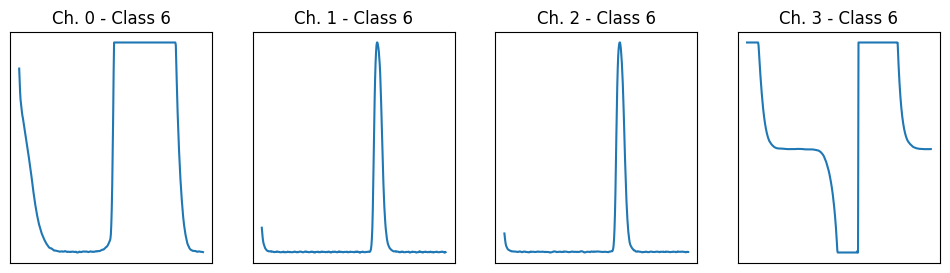

In [19]:
import random
import matplotlib.pyplot as plt

for class_label in range(1, 7):
    class_indices = [i for i, label in enumerate(Y_train) if label == class_label]

    random_index = random.choice(class_indices)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].plot(X_train[random_index, :, 0])
    axes[0].set_title(f"Ch. 0 - Class {class_label}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].plot(X_train[random_index, :, 1])
    axes[1].set_title(f"Ch. 1 - Class {class_label}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].plot(X_train[random_index, :, 2])
    axes[2].set_title(f"Ch. 2 - Class {class_label}")
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[3].plot(X_train[random_index, :, 3])
    axes[3].set_title(f"Ch. 3 - Class {class_label}")
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    plt.show()

[ 0.27608426  0.0198544  -0.01571807 -1.51158612]
[ 0.31443618  0.01075447  0.03309067 -0.13652416]
[ 0.29591078  0.02895433 -0.00579087 -0.10288104]
[0.32747831 0.02068167 0.07776307 0.73358116]
[0.03565675 0.13898081 0.18530774 0.04702602]


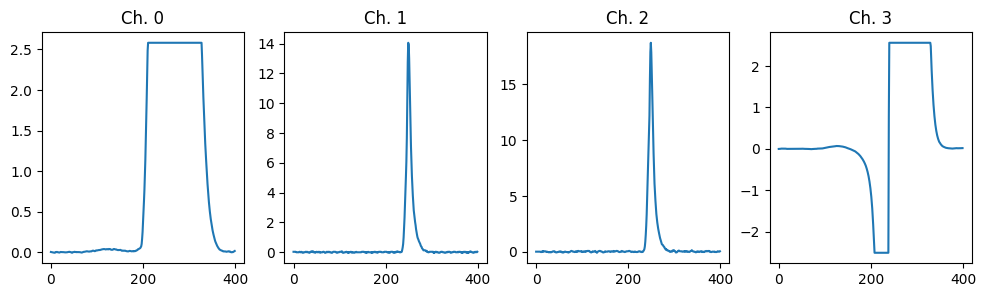

In [20]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

random_indices = [random.randint(0, 140081) for _ in range(5)]

for idx in random_indices:
    print(X_train[idx, 199, :])

In [21]:
# APPLY INCANDESCENT THRESHOLD
mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

In [22]:
import numpy as np

unique_classes_orig, class_counts_orig = np.unique(Y_train, return_counts=True)

mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train_filtered = X_train[mask]
Y_train_filtered = Y_train[mask]

unique_classes_after, class_counts_after = np.unique(Y_train_filtered, return_counts=True)

print("Different aerosol classes detectable incandesence:")
for cls in unique_classes_orig:
    count_orig = class_counts_orig[unique_classes_orig == cls][0]
    count_after = class_counts_after[unique_classes_after == cls][0] if cls in unique_classes_after else 0
    percentage_change = (count_after / count_orig) * 100 if count_orig > 0 else 0
    print(f"Class {cls}: Before = {count_orig}, After = {count_after}, Percentage = {percentage_change:.2f}%")

Different aerosol classes detectable incandesence:
Class 0.0: Before = 19660, After = 19660, Percentage = 100.00%
Class 1.0: Before = 16223, After = 16223, Percentage = 100.00%
Class 2.0: Before = 1706, After = 1706, Percentage = 100.00%
Class 3.0: Before = 4786, After = 4786, Percentage = 100.00%
Class 4.0: Before = 5402, After = 5402, Percentage = 100.00%
Class 5.0: Before = 18377, After = 18377, Percentage = 100.00%
Class 6.0: Before = 19678, After = 19678, Percentage = 100.00%


In [24]:
max1 = np.max(X_train[:, :, 1], axis=1)
max2 = np.max(X_train[:, :, 2], axis=1)

# Calculate the color channel ratio for all 400 points
color_channel_ratio = max2 / max1

color_channel_ratio

array([1.11002002, 1.08262394, 1.21032505, ..., 1.52508171, 1.49707908,
       1.61149563])

In [25]:
channel_min_X_train = np.zeros((len(X_train), 4))
channel_max_X_train = np.zeros((len(X_train), 4))

for p_idx in range(len(X_train)):
  for c_idx in range(4):
    channel_min_X_train[p_idx][c_idx] = np.min(X_train[p_idx, :, c_idx])

  for c_idx in range(4):
    channel_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])


for p_idx in range (0,len(X_train)):
  for c_idx in range(0, 4):
    s0 = (X_train[p_idx,:,c_idx] - channel_min_X_train[p_idx][c_idx])/(channel_max_X_train[p_idx][c_idx]- channel_min_X_train[p_idx][c_idx])
    X_train[p_idx,:,c_idx] = s0

X_train.shape


(85832, 400, 4)

## Train VAE models on Ch. 0 and Ch. 1

In [26]:
X_train_C0 = torch.from_numpy(X_train[:,:, 0]).float()
train_loader_0 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

X_train_C1 = torch.from_numpy(X_train[:,:, 1]).float()
train_loader_1 = pv.utils.init_dataloader(X_train_C1.unsqueeze(1), batch_size=64)

In [28]:
# Initialize vanilla VAE
vae0 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

In [29]:
# Train for n epochs:
for e in range(55):
    trainer.step(train_loader_0)
    trainer.print_statistics()
torch.save(vae0.state_dict(), "2DVAE_Ch0.pth")

Epoch: 1 Training loss: 104.5246
Epoch: 2 Training loss: 100.5075
Epoch: 3 Training loss: 100.0632
Epoch: 4 Training loss: 99.7383
Epoch: 5 Training loss: 99.5326
Epoch: 6 Training loss: 99.3815
Epoch: 7 Training loss: 99.2667
Epoch: 8 Training loss: 99.1740
Epoch: 9 Training loss: 99.1131
Epoch: 10 Training loss: 99.0273
Epoch: 11 Training loss: 98.9871
Epoch: 12 Training loss: 98.9403
Epoch: 13 Training loss: 98.8594
Epoch: 14 Training loss: 98.8539
Epoch: 15 Training loss: 98.7984
Epoch: 16 Training loss: 98.7833
Epoch: 17 Training loss: 98.7848
Epoch: 18 Training loss: 98.7166
Epoch: 19 Training loss: 98.6906
Epoch: 20 Training loss: 98.6823
Epoch: 21 Training loss: 98.6877
Epoch: 22 Training loss: 98.6675
Epoch: 23 Training loss: 98.6519
Epoch: 24 Training loss: 98.6219
Epoch: 25 Training loss: 98.6375
Epoch: 26 Training loss: 98.6030
Epoch: 27 Training loss: 98.6253
Epoch: 28 Training loss: 98.6121
Epoch: 29 Training loss: 98.5750
Epoch: 30 Training loss: 98.5656
Epoch: 31 Traini

In [30]:
# Load in the trained model weights
vae0.load_state_dict(torch.load('2DVAE_Ch0.pth'))

<All keys matched successfully>

In [32]:
vae1 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae1)

In [33]:
# Train for n epochs:
for e in range(55):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae1.state_dict(), "2DVAE_Ch1.pth")

Epoch: 1 Training loss: 102.0565
Epoch: 2 Training loss: 97.4187
Epoch: 3 Training loss: 96.9739
Epoch: 4 Training loss: 96.7670
Epoch: 5 Training loss: 96.6309
Epoch: 6 Training loss: 96.5485
Epoch: 7 Training loss: 96.4878
Epoch: 8 Training loss: 96.4382
Epoch: 9 Training loss: 96.4058
Epoch: 10 Training loss: 96.3718
Epoch: 11 Training loss: 96.3534
Epoch: 12 Training loss: 96.3277
Epoch: 13 Training loss: 96.3078
Epoch: 14 Training loss: 96.3004
Epoch: 15 Training loss: 96.2773
Epoch: 16 Training loss: 96.2757
Epoch: 17 Training loss: 96.2644
Epoch: 18 Training loss: 96.2373
Epoch: 19 Training loss: 96.2317
Epoch: 20 Training loss: 96.2197
Epoch: 21 Training loss: 96.2021
Epoch: 22 Training loss: 96.1954
Epoch: 23 Training loss: 96.2008
Epoch: 24 Training loss: 96.1718
Epoch: 25 Training loss: 96.1747
Epoch: 26 Training loss: 96.1550
Epoch: 27 Training loss: 96.1568
Epoch: 28 Training loss: 96.1438
Epoch: 29 Training loss: 96.1384
Epoch: 30 Training loss: 96.1369
Epoch: 31 Training

In [34]:
# Load in the trained model weights
vae1.load_state_dict(torch.load('2DVAE_Ch1.pth'))

<All keys matched successfully>

## Analyze the latent manifolds for Ch. 0 and Ch. 1

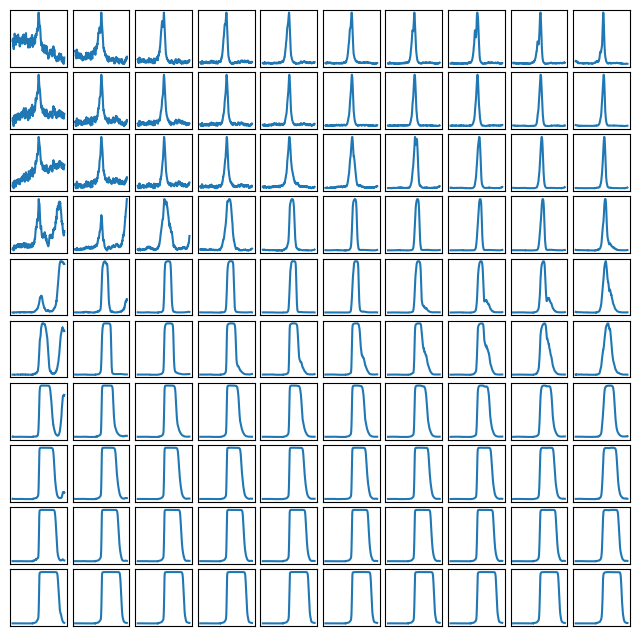

In [36]:
# Manifold Channel 0 (Scattering Channel)
manifold0 = vae0.manifold2d(d = 10)

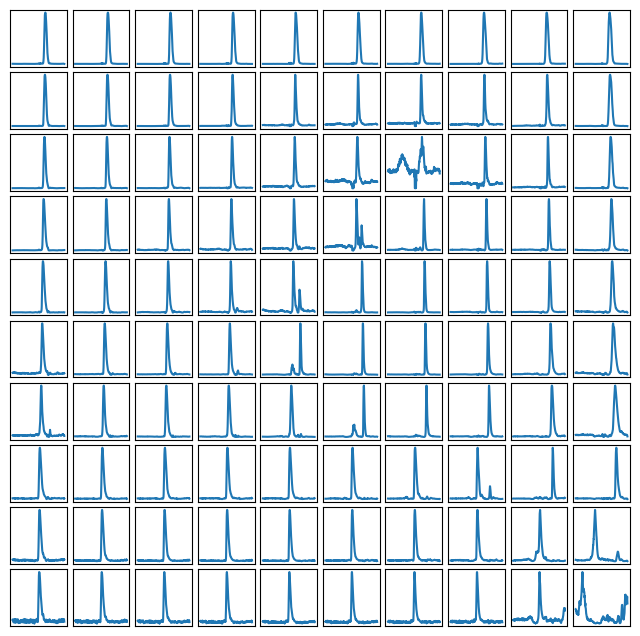

In [37]:
# Manifold Channel 1 (Incandescent Channel)
manifold1 = vae1.manifold2d(d = 10)